## In This Notebook we will calculate residuals from our Random Forest Models

In [12]:
import math

#### Making our wokring directory

In [13]:
# Set a working directory
import os

directory_path = '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/'
os.chdir(directory_path)


In [14]:
%run python/04_Populations-model-fitting/01_model-preparation.ipynb


In [15]:
import pandas as pd

tn413_path = 'data/modified/RF_ready_tn413.csv'
#using pandas to read in as a df
tn413 = (pd.read_csv(tn413_path,parse_dates=[0]))
#taking a peak at the data
tn413.head(3)


,population,time,lat,lon,NO3NO2,PO4,Fe,SiO4,Satellite_CHL,temp,salin,biomass
0,non_pro_syn,2023-02-25 05:40:00,21.3067,-157.036600,0.000562,0.212505,0.000433,2.092356,0.072018,24.03829,34.93311,6.716405
1,non_pro_syn,2023-02-25 05:50:00,21.3142,-157.032100,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,10.023072
2,prochloro,2023-02-25 05:50:00,21.3141,-157.031633,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,3.441297


### First we will load each random forest model into our notebook

In [16]:
import joblib
# Prochlorooccus
rf_pro = joblib.load("RF_models/random_forest_pro.joblib")

# Synechococus
rf_syn = joblib.load("RF_models/random_forest_syn.joblib")

# None Pro or Syn
rf_non = joblib.load("RF_models/random_forest_non.joblib")


## To make residuals we will predict on all available data for each picophytoplankton's population

In [17]:
def add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413):
    # Filter dataframes based on PopulationName
    dfs = [tn413[tn413['population'] == name].copy() for name in ['prochloro', 'synecho', 'non_pro_syn']]
    
    # Use the forest's predict method on the test data
    predictions = [rf.predict(features) for rf, features in zip([rf_pro, rf_syn, rf_non], [features_pro, features_syn, features_non])]
    
    # Add 'Prediction' and 'Errors' columns to each dataframe
    for df, preds in zip(dfs, predictions):
        df.rename(columns={'biomass': 'Actual'}, inplace=True)
        df['Prediction'] = preds
        df['residuals'] = df['Actual'] - df['Prediction']
        
    
    return dfs[0], dfs[1], dfs[2]

# Call the function and assign the returned dataframes to variables
rf_pro, rf_syn, rf_non = add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413)



In [19]:
rf_pro

,population,time,lat,lon,NO3NO2,PO4,Fe,SiO4,Satellite_CHL,temp,salin,Actual,Prediction,residuals
2,prochloro,2023-02-25 05:50:00,21.314100,-157.031633,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,3.441297,3.185283,0.256014
4,prochloro,2023-02-25 06:00:00,21.312500,-157.019100,0.000562,0.212505,0.000433,2.092356,0.072018,23.98739,34.93976,3.929065,3.329324,0.599741
6,prochloro,2023-02-25 06:10:00,21.311667,-156.997433,0.000534,0.211138,0.000450,2.089565,0.072336,23.98893,34.94376,3.386742,2.590640,0.796103
8,prochloro,2023-02-25 06:20:00,21.311167,-156.982933,0.000534,0.211138,0.000450,2.089565,0.072336,23.98837,34.94295,3.329084,2.632280,0.696804
10,prochloro,2023-02-25 06:30:00,21.309400,-156.963100,0.000534,0.211138,0.000450,2.089565,0.072336,24.00662,34.96166,2.862350,2.621811,0.240539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,prochloro,2023-03-08 18:10:00,-8.532000,-180.358900,0.001274,0.318895,0.000018,2.001196,0.053054,29.69008,35.30232,2.292807,2.292646,0.000161
3624,prochloro,2023-03-08 18:30:00,-8.596900,-180.381700,0.001274,0.318895,0.000018,2.001196,0.053054,29.69063,35.29094,1.995065,2.224908,-0.229843
3627,prochloro,2023-03-08 19:20:00,-8.746100,-180.438000,0.001274,0.318895,0.000018,2.001196,0.053054,29.70684,35.29260,1.540163,2.074379,-0.534216
3630,prochloro,2023-03-08 19:30:00,-8.781667,-180.452400,0.001317,0.313235,0.000020,2.038989,0.052806,29.71862,35.29352,1.433595,2.212969,-0.779374


In [22]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv
z_data = rf_pro.residuals
z = z_data.values

x = rf_pro.lat.values
y = rf_pro.lon.values
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [24]:
!pip install plotly==5.15.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 954.7 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: plotly
    Found existing installation: plotly 5.14.1
    Uninstalling plotly-5.14.1:
      Successfully uninstalled plotly-5.14.1


In [71]:
import plotly.graph_objects as go

# Create a 3D scatter plot on a globe
fig = go.Figure(data=go.Scattergeo(
    lat=rf_pro['lat'],
    lon=rf_pro['lon'],
    mode='markers',
    marker=dict(
        size=4,
        color=rf_pro['residuals'],
        colorscale='RdBu',
        cmin=min(rf_pro['residuals']),
        cmax=max(rf_pro['residuals']),
        colorbar=dict(title='Residuals (pgC/L)')
    )
))

# Set the projection type to 'orthographic' for a globe
fig.update_geos(projection_type='orthographic')

# Set the title
fig.update_layout(title='Prochlorococcus Biomass Residuals')

# Show the figure
fig.show()
fig.write_html('figures/globe_heatmap-residuals_tn413.html')


In [59]:
import plotly.express as px
df = rf_pro


fig = px.scatter_3d(df, x='lat', y='lon', z='residuals', )
fig.update_layout(scene_aspectmode='data')
fig.update_traces(marker_size = 2)

fig.show()

In [52]:
rf_pro

,population,time,lat,lon,NO3NO2,PO4,Fe,SiO4,Satellite_CHL,temp,salin,Actual,Prediction,residuals
2,prochloro,2023-02-25 05:50:00,21.314100,-157.031633,0.000562,0.212505,0.000433,2.092356,0.072018,24.01350,34.92320,3.441297,3.185283,0.256014
4,prochloro,2023-02-25 06:00:00,21.312500,-157.019100,0.000562,0.212505,0.000433,2.092356,0.072018,23.98739,34.93976,3.929065,3.329324,0.599741
6,prochloro,2023-02-25 06:10:00,21.311667,-156.997433,0.000534,0.211138,0.000450,2.089565,0.072336,23.98893,34.94376,3.386742,2.590640,0.796103
8,prochloro,2023-02-25 06:20:00,21.311167,-156.982933,0.000534,0.211138,0.000450,2.089565,0.072336,23.98837,34.94295,3.329084,2.632280,0.696804
10,prochloro,2023-02-25 06:30:00,21.309400,-156.963100,0.000534,0.211138,0.000450,2.089565,0.072336,24.00662,34.96166,2.862350,2.621811,0.240539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,prochloro,2023-03-08 18:10:00,-8.532000,-180.358900,0.001274,0.318895,0.000018,2.001196,0.053054,29.69008,35.30232,2.292807,2.292646,0.000161
3624,prochloro,2023-03-08 18:30:00,-8.596900,-180.381700,0.001274,0.318895,0.000018,2.001196,0.053054,29.69063,35.29094,1.995065,2.224908,-0.229843
3627,prochloro,2023-03-08 19:20:00,-8.746100,-180.438000,0.001274,0.318895,0.000018,2.001196,0.053054,29.70684,35.29260,1.540163,2.074379,-0.534216
3630,prochloro,2023-03-08 19:30:00,-8.781667,-180.452400,0.001317,0.313235,0.000020,2.038989,0.052806,29.71862,35.29352,1.433595,2.212969,-0.779374


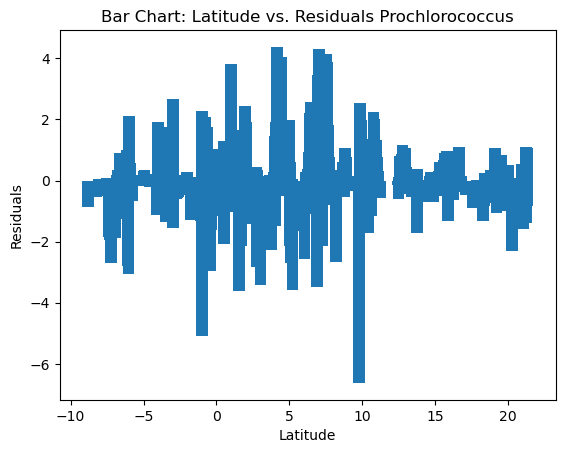

In [56]:
import matplotlib.pyplot as plt

# Extract the 'lat' and 'residuals' columns from the rf_pro dataframe
latitudes = rf_pro['lat']
residuals = rf_pro['residuals']

# Create a bar chart
plt.bar(latitudes, residuals)

# Set the x-axis label
plt.xlabel('Latitude')

# Set the y-axis label
plt.ylabel('Residuals')

# Set the title of the chart
plt.title('Bar Chart: Latitude vs. Residuals prochlorococcus')

# Display the chart
plt.show()


/Users/cristianswift/opt/anaconda3/envs/machine-learning-env/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


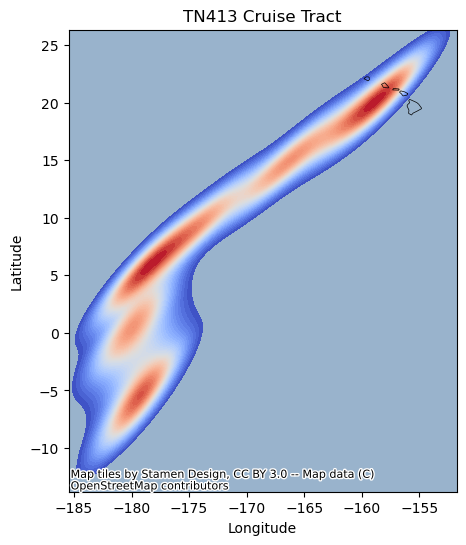

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def cruise_tract(dataframe):
    import pandas as pd
    import geopandas as gpd
    from geopandas import GeoSeries, GeoDataFrame
    import contextily as cx
    from shapely.geometry import Point

    # Create starting cruise tracks df that contains Nans
    cruise_tracks = dataframe[['time', 'lat', 'lon', 'residuals']]

    # Create the geometry column for mapping in GeoPandas
    geometry = [Point(xy) for xy in zip(cruise_tracks['lon'], cruise_tracks['lat'])]
    gdf = GeoDataFrame(cruise_tracks, geometry=geometry, crs='EPSG:4326')

    # Load the world map shapefile using GeoPandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create a GeoPandas plot of the world map
    fig, ax = plt.subplots(figsize=(10, 6))
    world.boundary.plot(ax=ax, linewidth=0.5, color='k')  # Plot the world map boundaries

    # Set the plot limits based on the cruise track geometry bounds
    bounds = gdf.geometry.bounds
    ax.set_xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
    ax.set_ylim([bounds.miny.min()-5, bounds.maxy.max()+5])

    # Set the title and labels for the plot
    ax.set_title('TN413 Cruise Tract')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add the cruise track as a line plot
    gdf.plot(linewidth=0.2, ax=ax)

    # Add a heatmap of the 'residuals' column using seaborn
    sns.kdeplot(data=gdf, x='lon', y='lat', fill=True, cmap='coolwarm', levels=50, ax=ax)

    # Set the background color of the plot to white
    ax.set_facecolor('white')

    # Add a basemap using contextily
    cx.add_basemap(ax)

    # Show the plot
    plt.show()

cruise_tract(rf_pro)


In [4]:
!pip install contextily

In [5]:
tn413 = tn413.sort_values('lat', ascending=False)

/Users/cristianswift/opt/anaconda3/envs/machine-learning-env/lib/python3.11/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 22 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


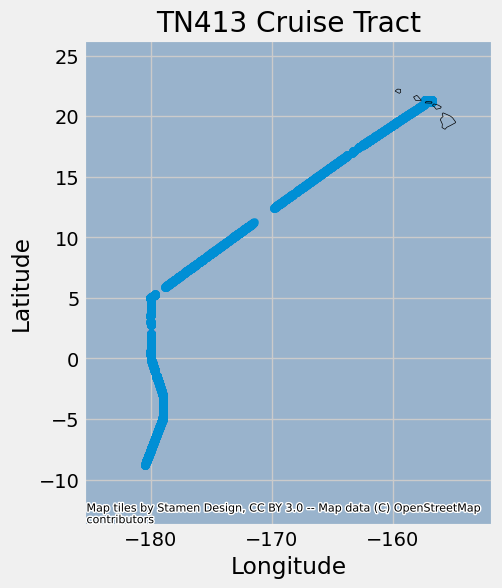

In [6]:
def cruise_tract(dataframe):
    import seaborn as sns
    import pandas as pd
    import geopandas as gpd
    from geopandas import GeoSeries, GeoDataFrame
    import contextily as cx


    # Create starting cruise tracks df that contains Nans
    cruise_tracks = dataframe[['date', 'lat', 'lon']]

    #creating a geometry dataframe to map in geopandas
    from shapely.geometry import Point
            #list comperehension
    geometry = [Point(xy) for xy in zip(cruise_tracks['lon'],
                                        cruise_tracks['lat'])]

    gdf = GeoDataFrame(cruise_tracks, geometry=geometry, crs=3857)

    # Load the world map shapefile using GeoPandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create a GeoPandas plot of the world map
    fig, ax = plt.subplots(figsize=(10, 6))
    world.boundary.plot(ax=ax, linewidth=0.5, color='k')  # plot the world map boundaries

    bounds = gdf.geometry.bounds

    ax.set_xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
    ax.set_ylim([bounds.miny.min()-5, bounds.maxy.max()+5])

    ax.set_title('Countries and Ocean Basins')

    gdf.plot(linewidth=0.2, ax=ax)
    # Set the background color of the plot to white
    ax.set_facecolor('white')

    # Set the title and labels for the plot
    ax.set_title('TN413 Cruise Tract')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    cx.add_basemap(ax)

    # Show the plot
    plt.show()

cruise_tract(tn413)

In [7]:
min(non_tn413['cell_diameter'])

1.2556657737807448

In [8]:
def add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413):
    # Filter dataframes based on PopulationName
    dfs = [tn413[tn413['PopulationName'] == name].copy() for name in ['prochloro', 'synecho', 'non_pro_syn']]
    
    # Use the forest's predict method on the test data
    predictions = [rf.predict(features) for rf, features in zip([rf_pro, rf_syn, rf_non], [features_pro, features_syn, features_non])]
    
    # Add 'Prediction' and 'Errors' columns to each dataframe
    for df, preds in zip(dfs, predictions):
        df.rename(columns={'biomass': 'Actual'}, inplace=True)
        df['Prediction'] = preds
        df['Errors'] = df['Actual'] - df['Prediction']
        
    
    return dfs[0], dfs[1], dfs[2]

# Call the function and assign the returned dataframes to variables
pro_tn413, syn_tn413, non_tn413 = add_predictions_to_dataframe(rf_pro, rf_syn, rf_non, features_pro, features_syn, features_non, tn413)



In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_variable_importance(models, model_titles, feature_list):
    num_models = len(models)

    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 5))

    label_mapping = {
        'NO3NO2': 'Nitrate',
        'PO4': 'Phosphate',
        'Fe': 'Iron',
        'Satellite_CHL': 'Chlorophyll',
        'temp': 'Temperature',
        'salin': 'Salinity'
    }

    for i in range(num_models):
        model = models[i]
        feature_importance = pd.DataFrame(model.feature_importances_, index=feature_list).sort_values(by=0, ascending=False)

        ax = axes[i]
        ax.bar(x=feature_importance.index, height=feature_importance[0], orientation='vertical')

        ax.set_title(model_titles[i])
        ax.set_ylabel('Importance')
        ax.set_xticks(range(len(feature_importance.index)))
        ax.set_xticklabels([label_mapping[label] for label in feature_importance.index], rotation=45, ha='right', rotation_mode='anchor')

    fig.suptitle('Variable Importances for Random Forest Models', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


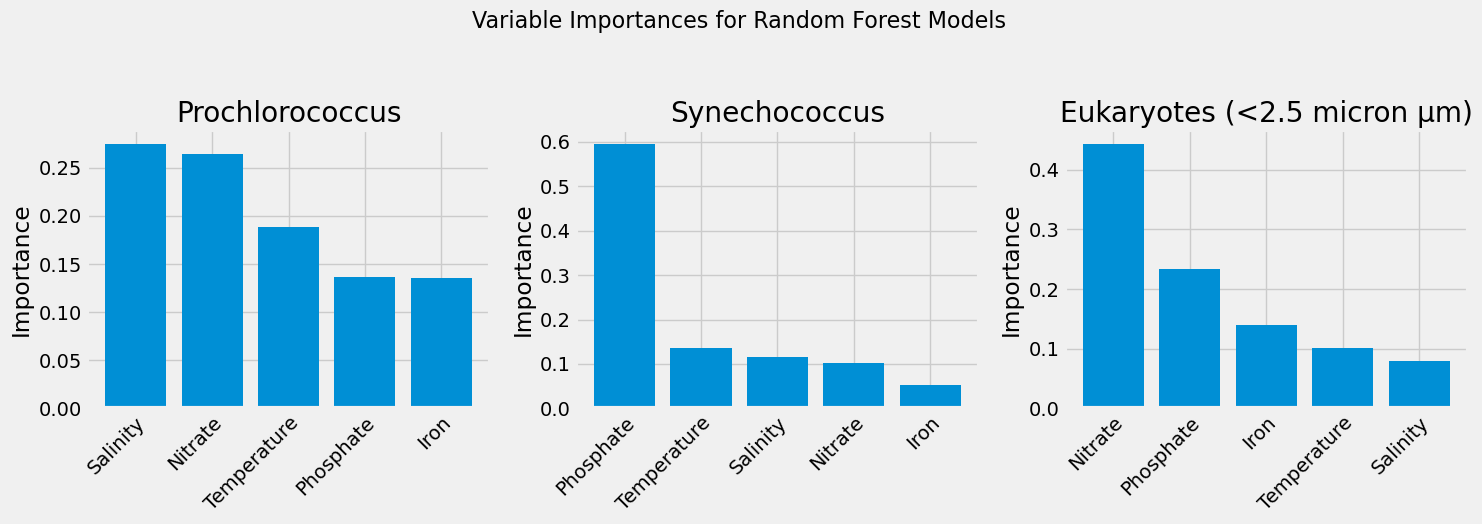

In [10]:
# Define the titles for each model
label_mapping = {
    'NO3NO2': 'Nitrate',
    'Fe': 'Iron',
    'PO4': 'Phosphate',
    'Satellite_CHL': 'Chlorophyll',
    'temp': 'Temperature',
    'salin': 'Salinity'
}
model_titles = ['Prochlorococcus', 'Synechococcus', 'Eukaryotes (<2.5 micron µm)']
models = [rf_pro, rf_syn, rf_non]
plot_variable_importance(models, model_titles, feature_list)


## Find justification for choosing test size

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Rsquared Score for DTree Regression

def plot_model_predidctions(pro_tn413, syn_tn413, non_tn413):
    fig, axs = plt.subplots(1, 3, figsize=(17, 7))

    # PRO Model Predictions vs True Values
    axs[0].scatter(pro_tn413['Actual'], pro_tn413['Prediction'])
    axs[0].set_title('PRO Model Predictions vs True Values')
    axs[0].set_ylim(ymin=0)
    axs[0].set_xlim(xmin=0)
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    axs[0].set_aspect('equal')
    
    # SYN Model Predictions vs True Values
    axs[1].scatter(syn_tn413['Actual'], syn_tn413['Prediction'])
    axs[1].set_title('SYN Model Predictions vs True Values')
    axs[1].set_ylim(ymin=0)
    axs[1].set_xlim(xmin=0)
    axs[1].set_xlabel('True Values')
    axs[1].set_ylabel('Predictions')
    axs[1].set_aspect('equal')
    
    # NON Model Predictions vs True Values
    axs[2].scatter(non_tn413['Actual'], non_tn413['Prediction'])
    axs[2].set_title('NON Model Predictions vs True Values')
    axs[2].set_ylim(ymin=0)
    axs[2].set_xlim(xmin=0)
    axs[2].set_xlabel('True Values')
    axs[2].set_ylabel('Predictions')
    axs[2].set_aspect('equal')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


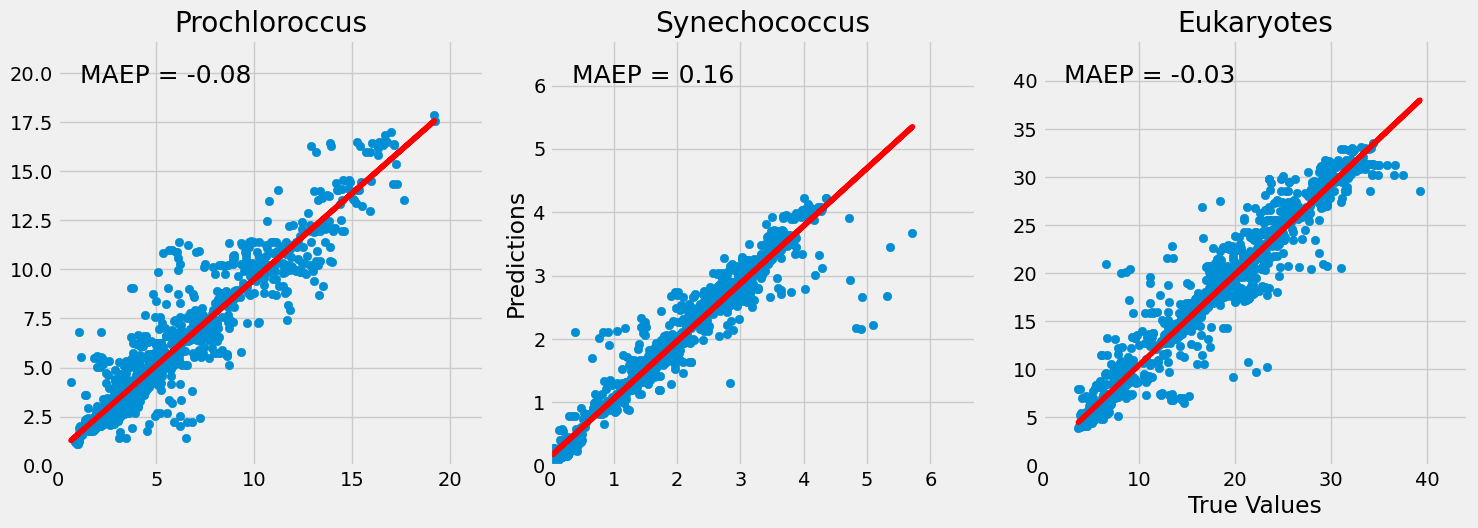

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

def plot_model_predictions(pro_tn413, syn_tn413, non_tn413):
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    # PRO Model Predictions vs True Values
    
    one_over_n_pro = 1/len(pro_tn413) 
    
    pro_maep = one_over_n_pro*sum(
    (pro_tn413['Actual'] - pro_tn413['Prediction'])
    /
    pro_tn413['Actual'])
    
    pro_mae = mean_absolute_error(pro_tn413['Actual'], pro_tn413['Prediction'])
    axs[0].scatter(pro_tn413['Actual'], pro_tn413['Prediction'])
    axs[0].text(0.05, 0.9, 'MAEP = {:.2f}'.format(pro_maep), transform=axs[0].transAxes, fontsize=18)
    axs[0].set_title('Prochloroccus')
    axs[0].set_ylim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    axs[0].set_xlim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    axs[0].set_aspect('equal')
    # Add linear regression line
    x = pro_tn413['Actual']
    y = pro_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[0].plot(x, slope*x + intercept, color='red')
    
    # SYN Model Predictions vs True Values
    
    one_over_n_syn = 1/len(syn_tn413) 
    syn_maep = one_over_n_syn*sum(
    (syn_tn413['Actual'] - syn_tn413['Prediction'])
    /
    syn_tn413['Actual'])
    syn_mae = mean_absolute_error(syn_tn413['Actual'], syn_tn413['Prediction'])
    axs[1].scatter(syn_tn413['Actual'], syn_tn413['Prediction'])
    axs[1].text(0.05, 0.9, 'MAEP = {:.2f}'.format(syn_mae), transform=axs[1].transAxes, fontsize=18)
    axs[1].set_title('Synechococcus')
    axs[1].set_ylim(0, max(syn_tn413['Actual'].max(), syn_tn413['Prediction'].max())+1)
    axs[1].set_xlim(0, max(syn_tn413['Actual'].max(), syn_tn413['Prediction'].max())+1)
    axs[1].set_ylabel('Predictions')
    axs[1].set_aspect('equal')
    # Add linear regression line
    x = syn_tn413['Actual']
    y = syn_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[1].plot(x, slope*x + intercept, color='red')
    
    # NON Model Predictions vs True Values
    
    one_over_n_non = 1/len(non_tn413) 
    non_maep = one_over_n_non*sum(
    (non_tn413['Actual'] - non_tn413['Prediction'])
    /
    non_tn413['Actual'])
    
    non_mae = mean_absolute_error(non_tn413['Actual'], non_tn413['Prediction'])
    axs[2].scatter(non_tn413['Actual'], non_tn413['Prediction'])
    axs[2].text(0.05, 0.9, 'MAEP = {:.2f}'.format(non_maep), transform=axs[2].transAxes, fontsize=18)
    axs[2].set_title('Eukaryotes')
    axs[2].set_ylim(0, max(non_tn413['Actual'].max(), non_tn413['Prediction'].max())+5)
    axs[2].set_xlim(0, max(non_tn413['Actual'].max(), non_tn413['Prediction'].max())+5)
    axs[2].set_xlabel('True Values')
    axs[2].set_aspect('equal')
    # Add linear regression line
    x = non_tn413['Actual']
    y = non_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[2].plot(x, slope*x + intercept, color='red')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function
plot_model_predictions(pro_tn413, syn_tn413, non_tn413)


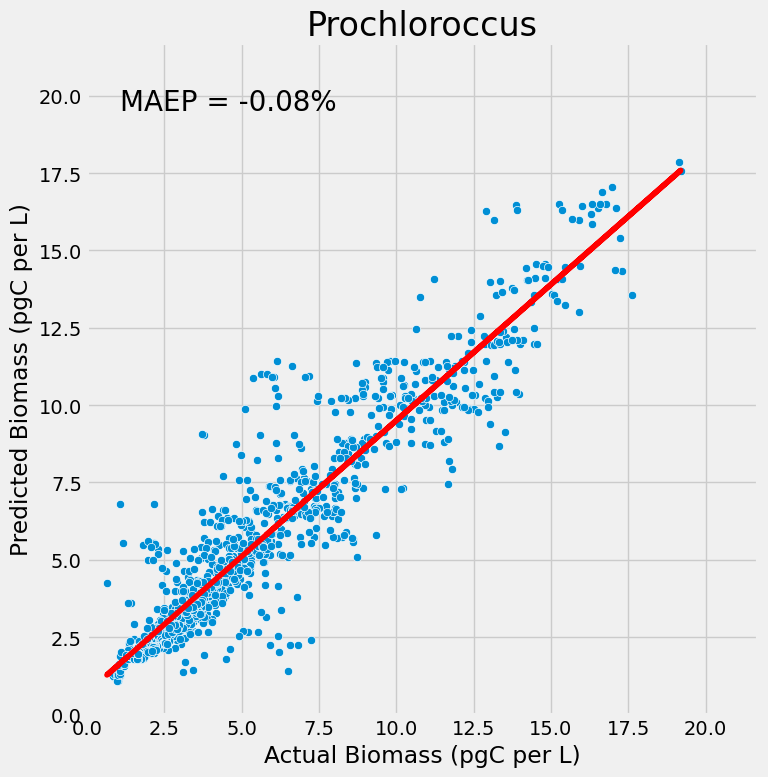

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

def plot_model_predictions(pro_tn413):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    
    one_over_n = 1/len(pro_tn413) 
    
    pro_maep = one_over_n*sum(
        (pro_tn413['Actual'] - pro_tn413['Prediction'])
        /
        pro_tn413['Actual'])
        
    # PRO Model Predictions vs True Values
    pro_mae = mean_absolute_error(pro_tn413['Actual'], pro_tn413['Prediction'])
    sns.scatterplot(x=pro_tn413['Actual'], y=pro_tn413['Prediction'])
    ax.text(0.05, 0.9, 'MAEP = {:.2f}%'.format(pro_maep), transform=ax.transAxes, fontsize=20)
    ax.set_title('Prochloroccus', fontsize=24)
    ax.set_xlabel('Actual Biomass (pgC per L)')
    ax.set_ylabel('Predicted Biomass (pgC per L)')
    ax.set_ylim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    ax.set_xlim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    ax.set_aspect('equal')
    ax.grid('on')

    # Add linear regression line
    x = pro_tn413['Actual']
    y = pro_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='red')




    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

# Call the function
plot_model_predictions(pro_tn413)


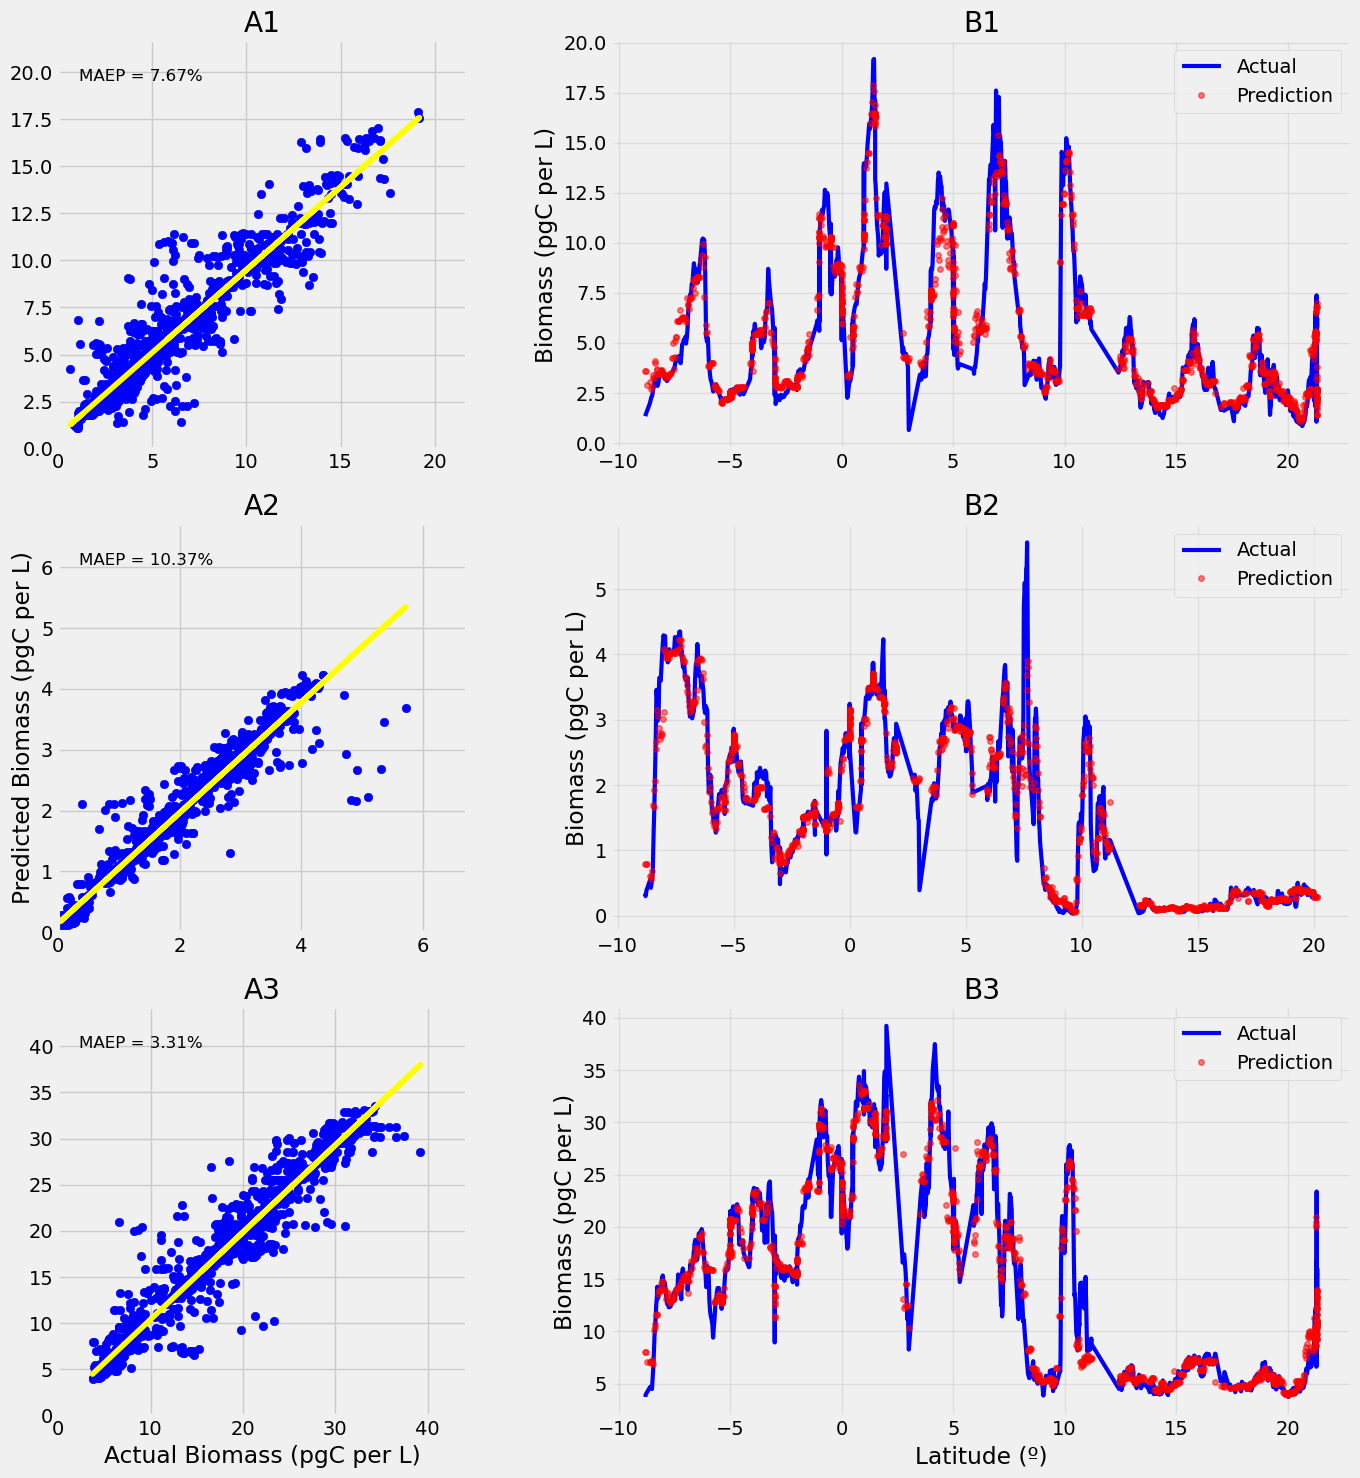

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

def plot_model_and_predicted_values(pro_tn413, syn_tn413, non_tn413, titles):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    one_over_n = 1/len(pro_tn413) 
    
    # PRO Model Predictions vs True Values
    pro_maep = abs(one_over_n*sum(
        (pro_tn413['Actual'] - pro_tn413['Prediction'])
        /
        pro_tn413['Actual']))*100
    axs[0, 0].scatter(pro_tn413['Actual'], pro_tn413['Prediction'], color='blue')
    axs[0, 0].text(0.05, 0.9, 'MAEP = {:.2f}%'.format(pro_maep), transform=axs[0, 0].transAxes, fontsize=12)
    axs[0, 0].set_title(titles[0])
    axs[0, 0].set_ylim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    axs[0, 0].set_xlim(0, max(pro_tn413['Actual'].max(), pro_tn413['Prediction'].max())+2.5)
    axs[0, 0].set_aspect('equal')
    # Add linear regression line
    x = pro_tn413['Actual']
    y = pro_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[0, 0].plot(x, slope*x + intercept, color='yellow')

    # SYN Model Predictions vs True Values
    one_over_n = 1/len(syn_tn413)
    syn_maep = abs(one_over_n*sum(
        (syn_tn413['Actual'] - syn_tn413['Prediction'])
        /
        syn_tn413['Actual'])) * 100
    axs[1, 0].scatter(syn_tn413['Actual'], syn_tn413['Prediction'], color='blue')
    axs[1, 0].text(0.05, 0.9, 'MAEP = {:.2f}%'.format(syn_maep), transform=axs[1, 0].transAxes, fontsize=12)
    axs[1, 0].set_title(titles[1])
    axs[1, 0].set_ylim(0, max(syn_tn413['Actual'].max(), syn_tn413['Prediction'].max())+1)
    axs[1, 0].set_xlim(0, max(syn_tn413['Actual'].max(), syn_tn413['Prediction'].max())+1)
    axs[1, 0].set_ylabel('Predicted Biomass (pgC per L)')
    axs[1, 0].set_aspect('equal')
    # Add linear regression line
    x = syn_tn413['Actual']
    y = syn_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[1, 0].plot(x, slope*x + intercept, color='yellow')

    # NON Model Predictions vs True Values
    one_over_n = 1/len(non_tn413)
    non_maep = abs(one_over_n*sum(
        (non_tn413['Actual'] - non_tn413['Prediction'])
        /
        non_tn413['Actual'])) * 100
    
    axs[2, 0].scatter(non_tn413['Actual'], non_tn413['Prediction'], color='blue')
    axs[2, 0].text(0.05, 0.9, 'MAEP = {:.2f}%'.format(non_maep), transform=axs[2, 0].transAxes, fontsize=12)
    axs[2, 0].set_title(titles[2])
    axs[2, 0].set_ylim(0, max(non_tn413['Actual'].max(), non_tn413['Prediction'].max())+5)
    axs[2, 0].set_xlim(0, max(non_tn413['Actual'].max(), non_tn413['Prediction'].max())+5)
    axs[2, 0].set_xlabel('Actual Biomass (pgC per L)')
    axs[2, 0].set_aspect('equal')
    # Add linear regression line
    x = non_tn413['Actual']
    y = non_tn413['Prediction']
    slope, intercept = np.polyfit(x, y, 1)
    axs[2, 0].plot(x, slope*x + intercept, color='yellow')

    # Actual and Predicted Values for each category
    dfs = [pro_tn413, syn_tn413, non_tn413]
    for i in range(len(dfs)):
        df = dfs[i]
        ax = axs[i, 1]

        # Plot the actual values as a blue line
        ax.plot(df['lat'], df['Actual'], linewidth=3, color='blue', label='Actual')

        # Plot the predicted values as red dots with transparency
        ax.plot(df['lat'], df['Prediction'], 'ro', markersize=4, alpha=0.5, label='Prediction')

        # Set x-axis tick rotation
        ax.tick_params(axis='x')

        # Add gridlines
        ax.grid(True, linestyle='-', alpha=0.5)

        # Set axis labels
        if i == len(dfs) - 1:
            ax.set_xlabel('Latitude (º)')
        ax.set_ylabel('Biomass (pgC per L)')

        # Set the title as the provided subplot title
        ax.set_title(titles[i])

        # Add a legend
        ax.legend()
    axs[0, 1].set_title('B1')
    axs[1, 1].set_title('B2')
    axs[2, 1].set_title('B3')

    # Adjust spacing between subplots
    plt.tight_layout()
    

    # Display the plot
    plt.show()

# Call the combined function
titles = ['A1', 'A2', 'A3']
dfs = [pro_tn413, syn_tn413, non_tn413]
plot_model_and_predicted_values(pro_tn413, syn_tn413, non_tn413, titles)


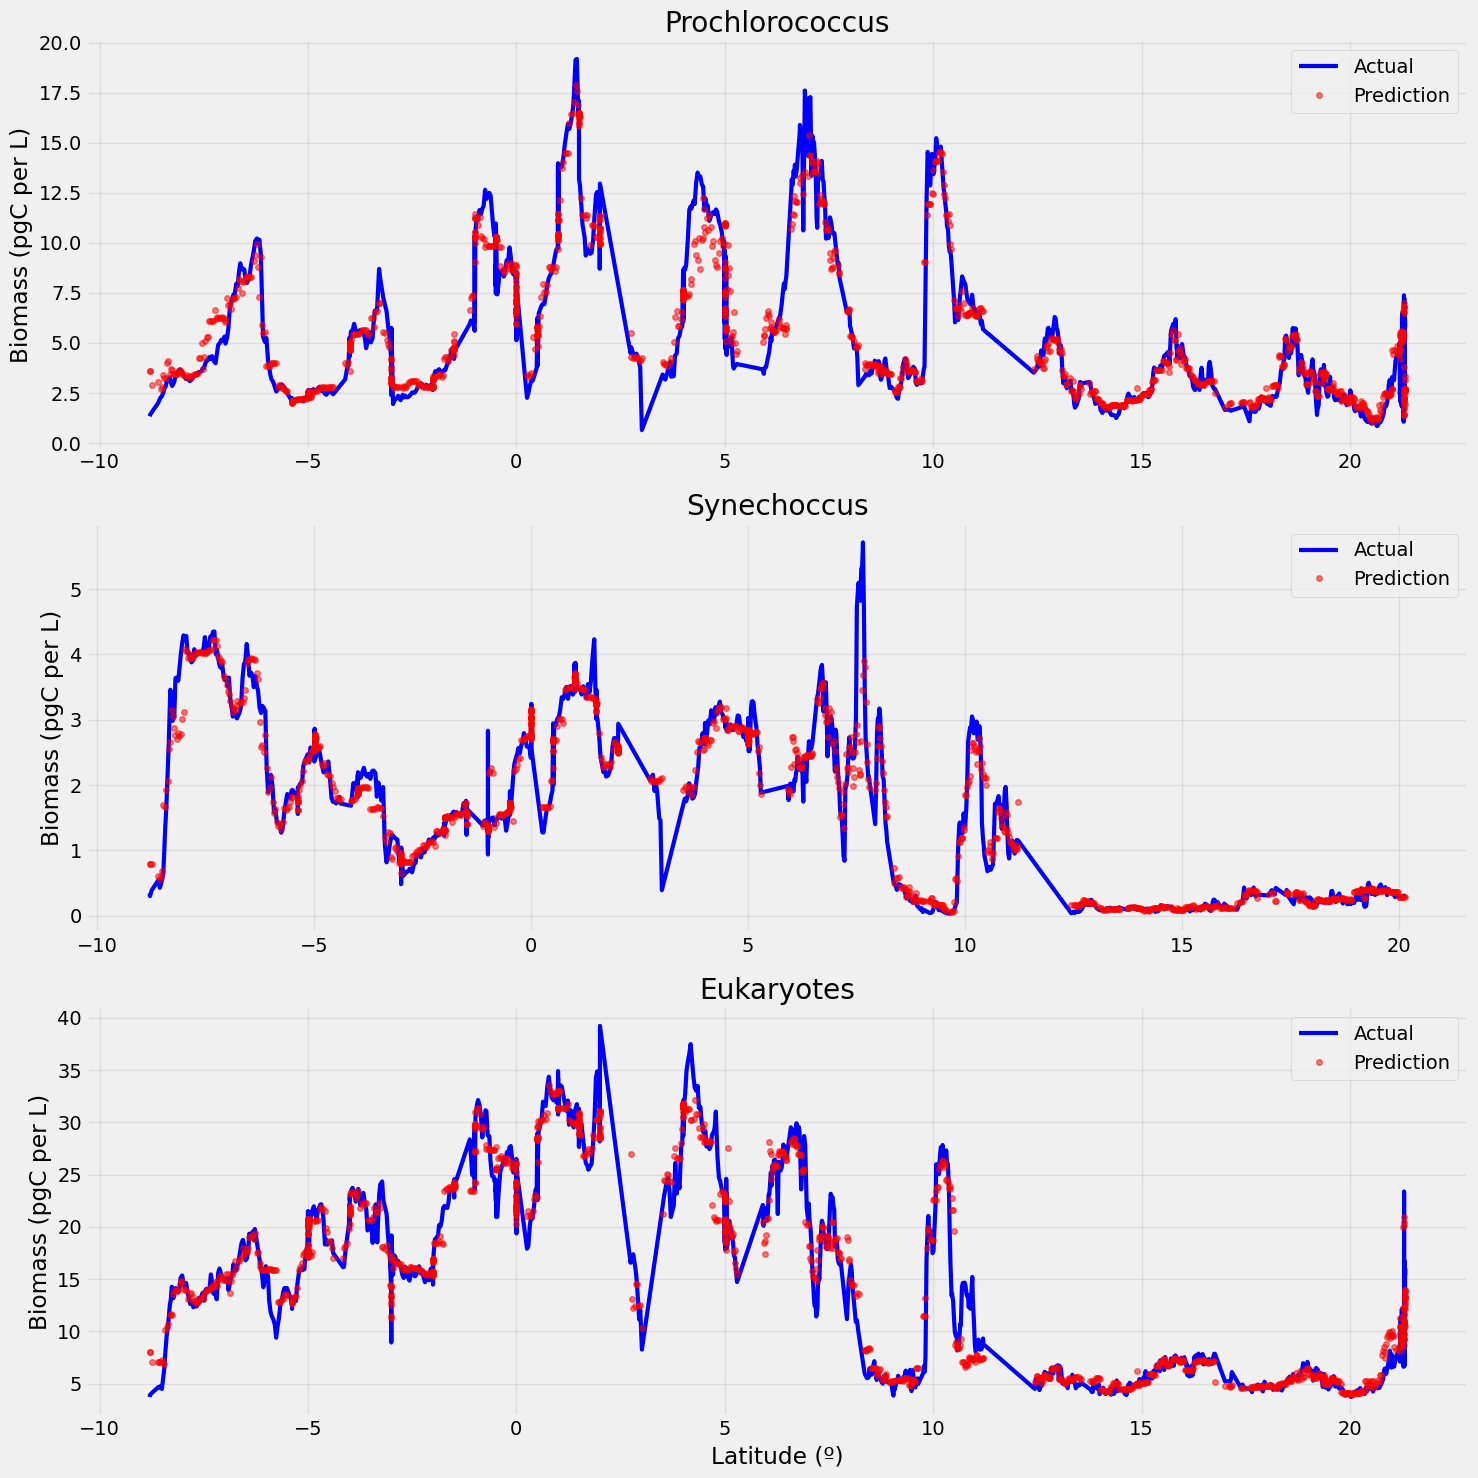

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_actual_and_predicted_values(dfs, titles):
    num_categories = len(dfs)
    fig, axs = plt.subplots(num_categories, 1, figsize=(15, 15))

    if num_categories == 1:
        axs = [axs]  # Wrap axs in a list if there's only one category

    for i in range(num_categories):
        df = dfs[i]
        ax = axs[i]

        # Plot the actual values as a blue line
        ax.plot(df['lat'], df['Actual'], linewidth=3, color='blue', label='Actual')

        # Plot the predicted values as red dots with transparency
        ax.plot(df['lat'], df['Prediction'], 'ro', markersize=4, alpha=0.5, label='Prediction')

        # Set x-axis tick rotation
        ax.tick_params(axis='x')

        # Add gridlines
        ax.grid(True, linestyle='-', alpha=0.5)

        # Set axis labels
        if i == num_categories - 1:
            ax.set_xlabel('Latitude (º)')
        ax.set_ylabel('Biomass (pgC per L)')

        # Set the title as the provided subplot title
        ax.set_title(titles[i])

        # Add a legend
        ax.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
titles = ['Prochlorococcus', 'Synechoccus', 'Eukaryotes']
dfs = [pro_tn413, syn_tn413, non_tn413]
plot_actual_and_predicted_values(dfs, titles)

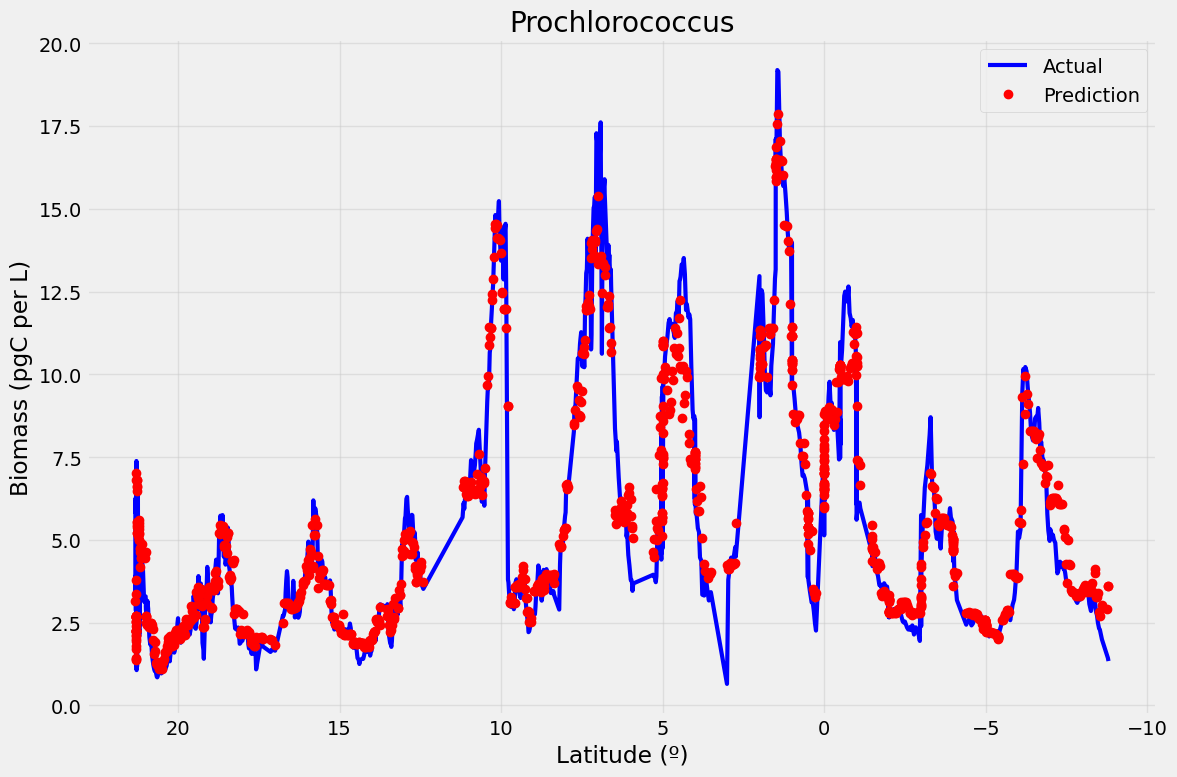

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_actual_predicted_values_1(df):
    num_categories = len(dfs)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    df = df.sort_values('lat', ascending=False)
    # Plot the actual values as a blue line
    ax.plot(df['lat'], df['Actual'], linewidth=3, color='blue', label='Actual')
    
    # Plot the predicted values as red dots with transparency
    ax.plot(df['lat'], df['Prediction'], 'ro', linewidth=2, label='Prediction')

    # Set x-axis tick rotation
    ax.tick_params(axis='x')

    # Add gridlines
    ax.grid(True, linestyle='-', alpha=0.5)

    # Set axis labels
    ax.set_xlabel('Latitude (º)')
    plt.gca().invert_xaxis()
    ax.legend(loc='upper right')  # Specify legend position
    ax.set_ylabel('Biomass (pgC per L)')

    # Set the title as the provided subplot title
    ax.set_title('Prochlorococcus')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


plot_actual_predicted_values_1(pro_tn413)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


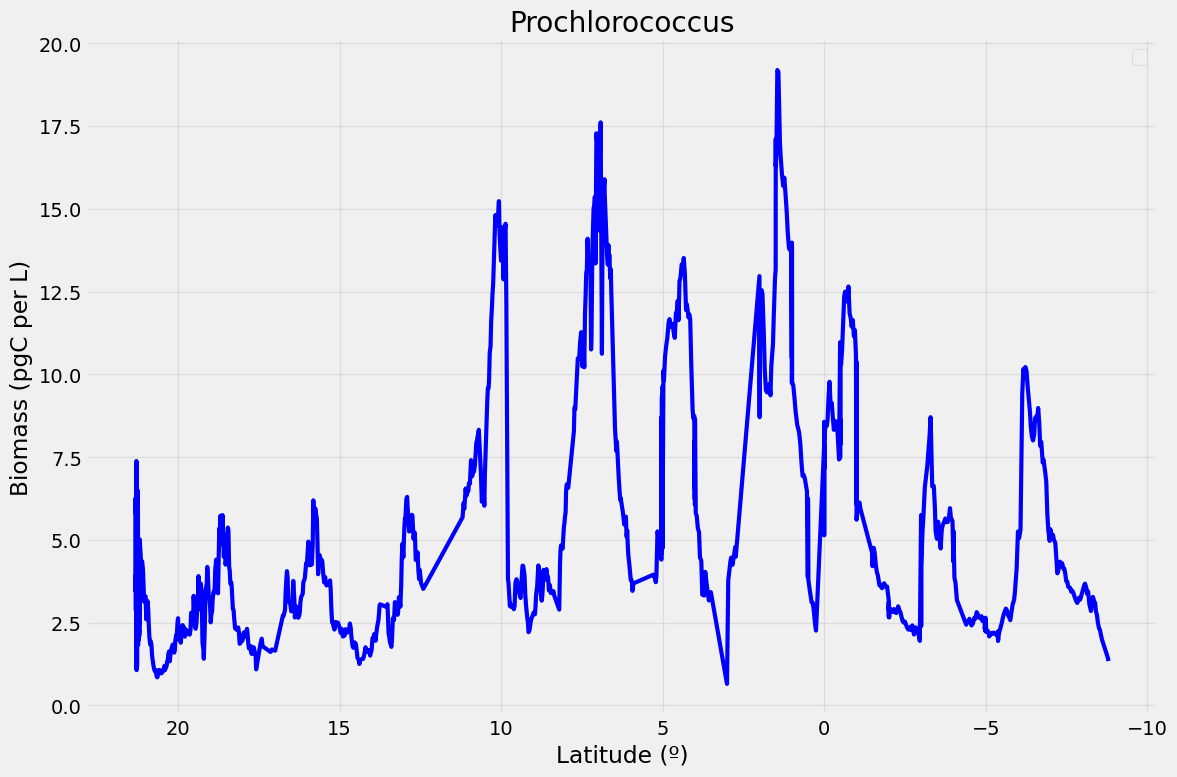

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_actual_values(df):
    num_categories = len(dfs)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))


    # Plot the actual values as a blue line
    ax.plot(df['lat'], df['Actual'], linewidth=3, color='blue')

    # Set x-axis tick rotation
    ax.tick_params(axis='x')

    # Add gridlines
    ax.grid(True, linestyle='-', alpha=0.5)

    # Set axis labels
    ax.set_xlabel('Latitude (º)')
    ax.set_ylabel('Biomass (pgC per L)')
    ax.legend()
    # Set the title as the provided subplot title
    ax.set_title('Prochlorococcus')
    plt.gca().invert_xaxis()

    # Adjust spacing between subplots
    plt.tight_layout()
    

    # Display the plot
    plt.show()
plot_actual_values(pro_tn413)

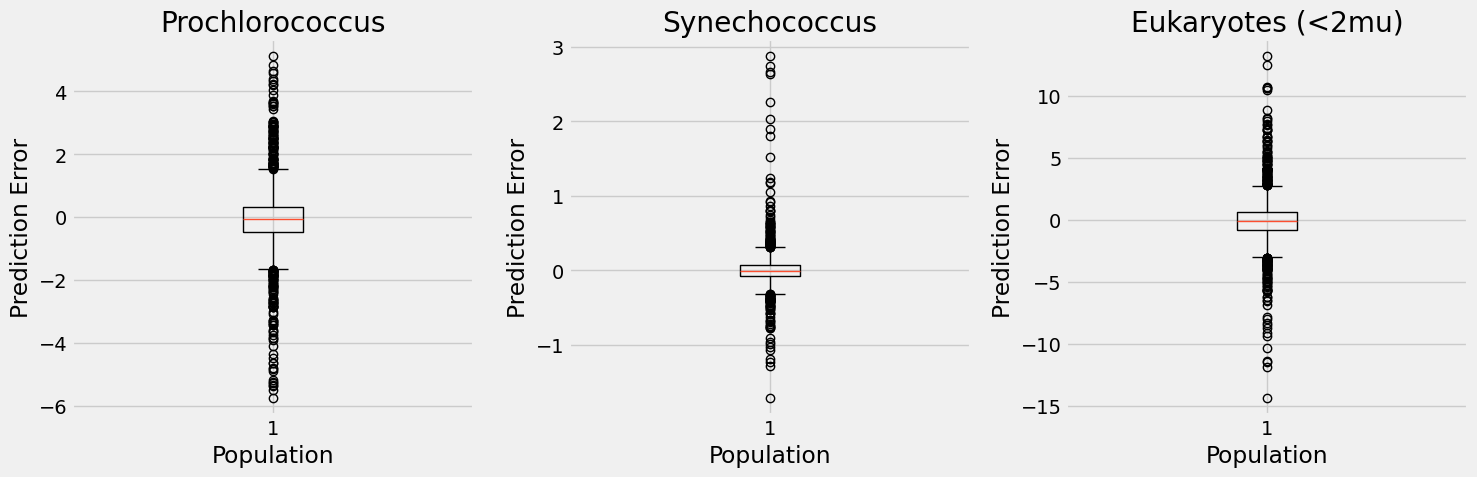

In [127]:
import matplotlib.pyplot as plt

def plot_errors_boxplot(pro_tn413, syn_tn413, non_tn413):
    # Combine the dataframes and create a list of errors
    errors = [pro_tn413['Errors'], syn_tn413['Errors'], non_tn413['Errors']]
    labels = ['pro', 'syn', 'non']

    # Create three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot boxplots for each population
    axs[0].boxplot(errors[0])
    axs[0].set_title('Prochlorococcus')
    axs[0].set_xlabel('Population')
    axs[0].set_ylabel('Prediction Error')

    axs[1].boxplot(errors[1])
    axs[1].set_title('Synechococcus')
    axs[1].set_xlabel('Population')
    axs[1].set_ylabel('Prediction Error')

    axs[2].boxplot(errors[2])
    axs[2].set_title('Eukaryotes (<2mu)')
    axs[2].set_xlabel('Population')
    axs[2].set_ylabel('Prediction Error')

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()
plot_errors_boxplot(pro_tn413, syn_tn413, non_tn413)

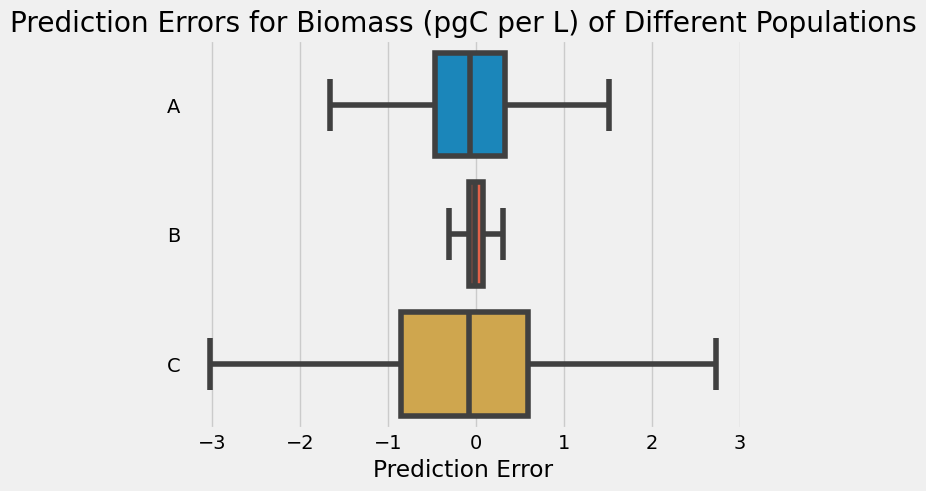

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_errors_boxplot(pro_tn413, syn_tn413, non_tn413):
    # Combine the dataframes and create a list of errors
    errors = [pro_tn413['Errors'], syn_tn413['Errors'], non_tn413['Errors']]
    labels = ['A', 'B', 'C']

    # Create a boxplot using seaborn
    sns.boxplot(data=errors, orient='h', showfliers = False)

    # Set the plot title and axis labels
    plt.title('Prediction Errors for Biomass (pgC per L) of Different Populations')
    plt.xlabel('Prediction Error')

    # Set the x-axis tick labels to the population names
    plt.yticks([0, 1, 2], labels)

    plt.show()
plot_errors_boxplot(pro_tn413, syn_tn413, non_tn413)

In [ ]:
errors = [
    labels = ['A', 'B', 'C']

    # Create a boxplot using seaborn
    sns.boxplot(data=errors, orient='h', showfliers = False)

In [129]:
plot_actual_and_predicted_values(features_pro, feature_list, label_pro, test_features_pro, predictions_pro, original_df=tn413,
                                title ='Actual and Predicted Values of Prochlorococcus Biomass')

TypeError: plot_actual_and_predicted_values() got an unexpected keyword argument 'original_df'

In [ ]:
pro_tn413.columns

In [ ]:
feature_list

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_features_with_predictions(data):
    fig, axs = plt.subplots(len(data.columns), 1, figsize=(8, 20), sharex=True, constrained_layout=True)
    predictions = data['Prediction']
    
    for i, ax in enumerate(axs):
        variable = data.columns[i]
        
        # Scatter plot of variable vs. predicted biomass
        ax.scatter(data[variable], predictions, alpha=0.5)
        
        # Set axis labels
        ax.set_xlabel(variable.capitalize())
        ax.set_ylabel('Predicted Biomass')
        
    # Adjust spacing between subplots
    plt.tight_layout(pad=1.5)
    
    # Display the plot
    plt.show()


plot_features_with_predictions(pro_tn413)


In [ ]:
plot_features_with_predictions(pro_tn413)